<a href="https://colab.research.google.com/github/kirbu123/LAB_PYTHON/blob/main/HW_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 3

In [1]:
!pip install -q catalyst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.7/446.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.3 MB/s eta 0:00:00


In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [17]:
'''class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn)
        self.bias = bias
        if bias:
            self.bias_term = # YOUR CODE GOES HERE

    def forward(self, x):
        x =  # YOUR CODE GOES HERE
        if self.bias:
            x +=  # YOUR CODE GOES HERE
        return x'''

SyntaxError: ignored

In [42]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(input_size, output_size))
        self.bias = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        logits = torch.matmul(x, self.weights) + self.bias
        return logits

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [5]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

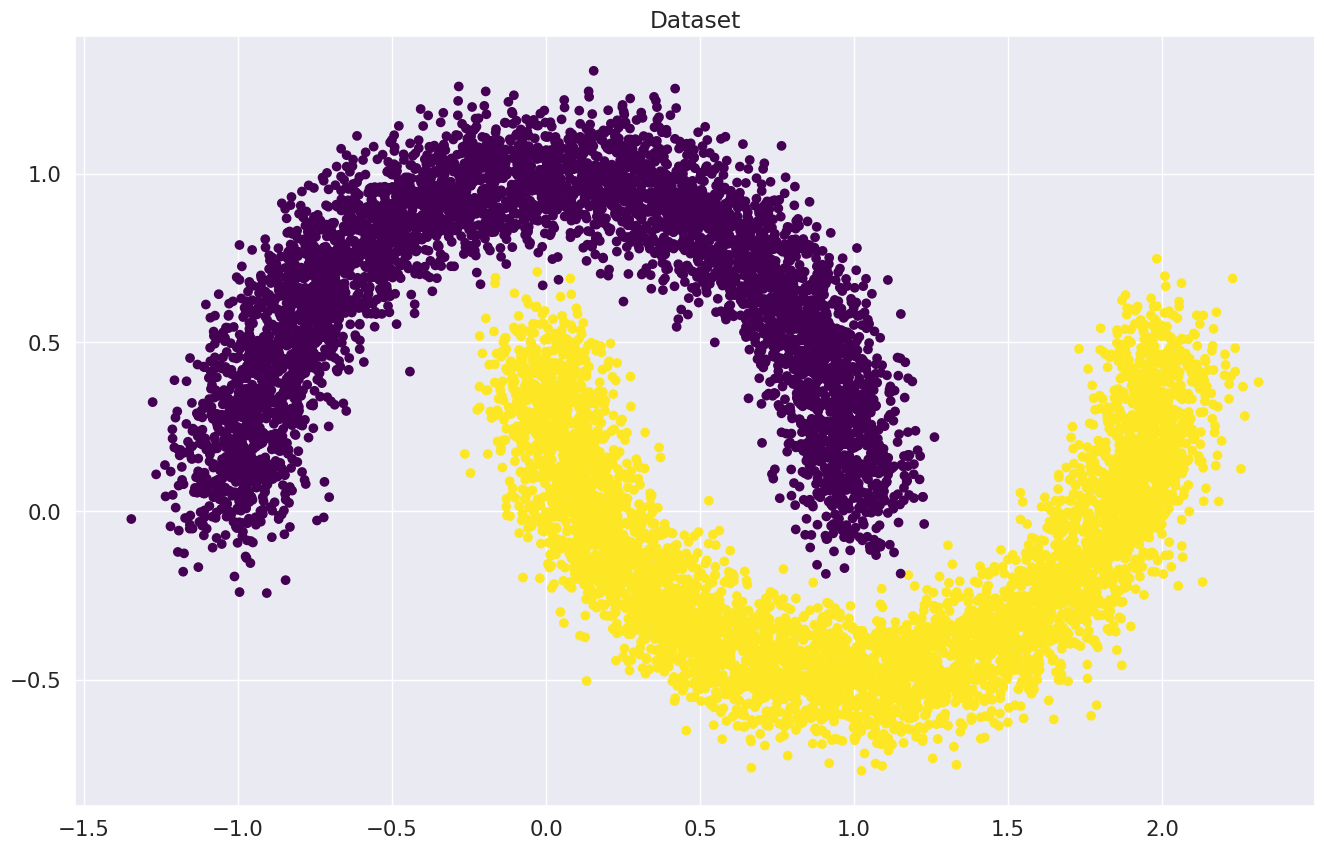

In [6]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [8]:
type(X_train)

numpy.ndarray

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [9]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

Создаем `Dataset` и `DataLoader`.

In [10]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [43]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [61]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch.float())
        loss = loss_function(outp.view(len(y_batch)), y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125

Iteration: 90047.Convergence. Stopping iterations.


In [62]:
type(y_batch[0].item())

int

**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

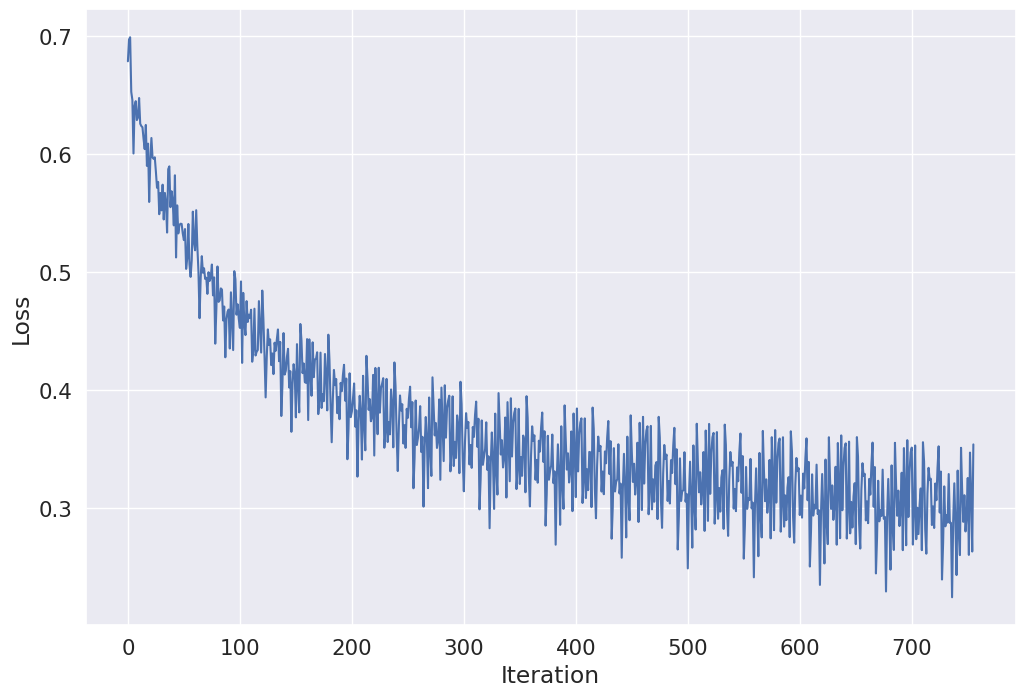

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

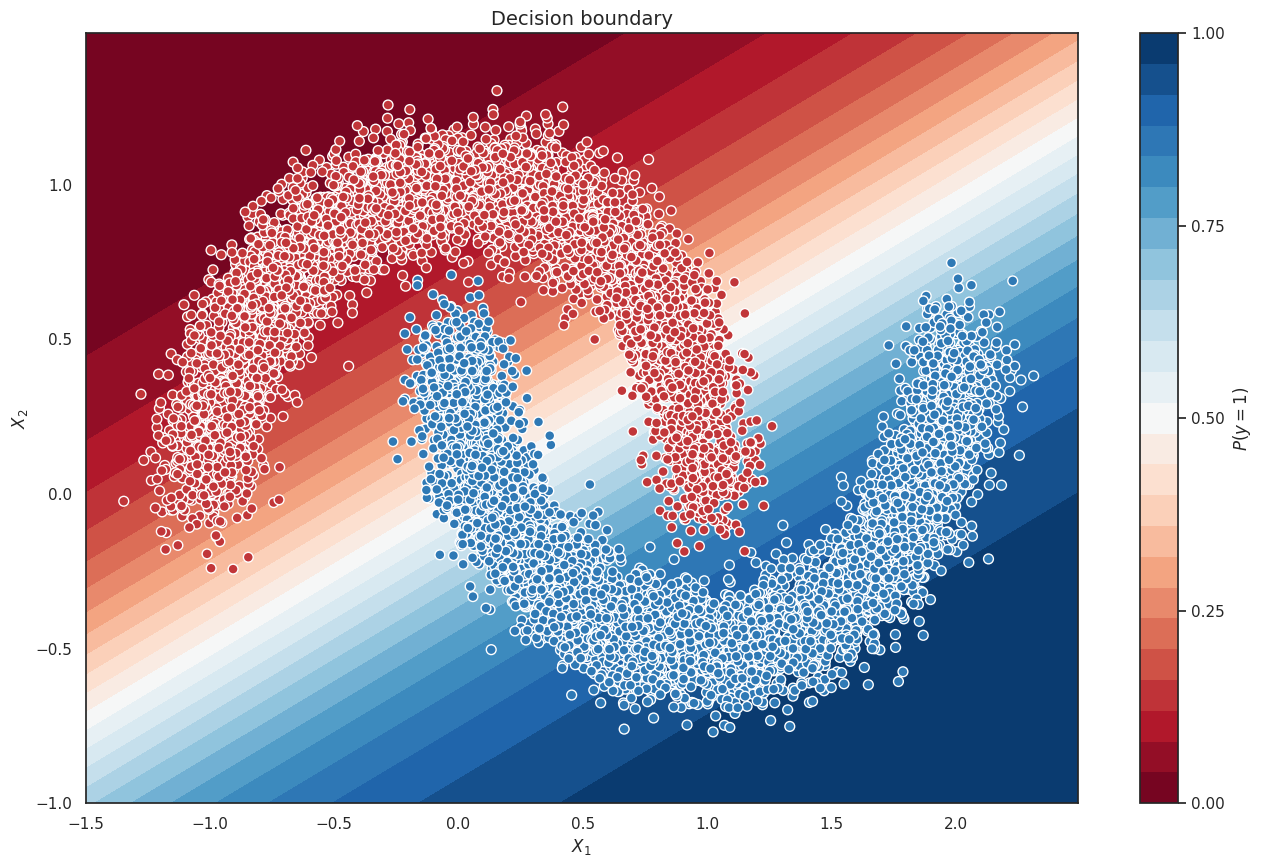

In [64]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [65]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [103]:
from sklearn.metrics import accuracy_score

outp = linear_regression.forward(X_val_t.float())
probabilities = torch.sigmoid(outp)
preds = (probabilities>0.5).type(torch.long)

preds.view(2500)

accuracy_score(preds.detach().view(len(y_val)).numpy(), y_val)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**

### MNIST

In [107]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [115]:
import os
from catalyst.contrib.datasets import MNIST

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root=os.getcwd(), train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root=os.getcwd(), train=False, transform=transform)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [116]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [151]:
activation = nn.ELU

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [152]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [153]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [148]:
from tqdm import tqdm_notebook

In [154]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in tqdm_notebook(loaders.items()):
        for x_batch, y_batch in tqdm_notebook(dataloader):
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)

            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            predict = torch.max(outp, 1).indices
            correct = (y_batch == predict)
            all = len(y_batch)
            epoch_correct += int(correct.int().sum())
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


<ipython-input-154-9106dccf6ad3>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(max_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-154-9106dccf6ad3>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, dataloader in tqdm_notebook(loaders.items()):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-154-9106dccf6ad3>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_batch, y_batch in tqdm_notebook(dataloader):


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9305


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9346714285714286


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9668833333333333


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9665714285714285


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9735166666666667


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9734571428571429


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9799


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9782


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9820333333333333


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9801428571428571


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9845


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9832714285714286


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9861666666666666


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9846571428571429


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9876166666666667


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9855857142857143


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9880333333333333


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9855142857142857


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9891166666666666


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9868285714285714


In [139]:
c = (y_batch == predict)

In [143]:
int(c.int().sum())

4

Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [155]:
plain_accuracy = accuracy["valid"]

In [156]:
relu_accuracy = accuracy["valid"]

In [157]:
leaky_relu_accuracy = accuracy["valid"]

In [158]:
elu_accuracy = accuracy["valid"]

### Accuracy

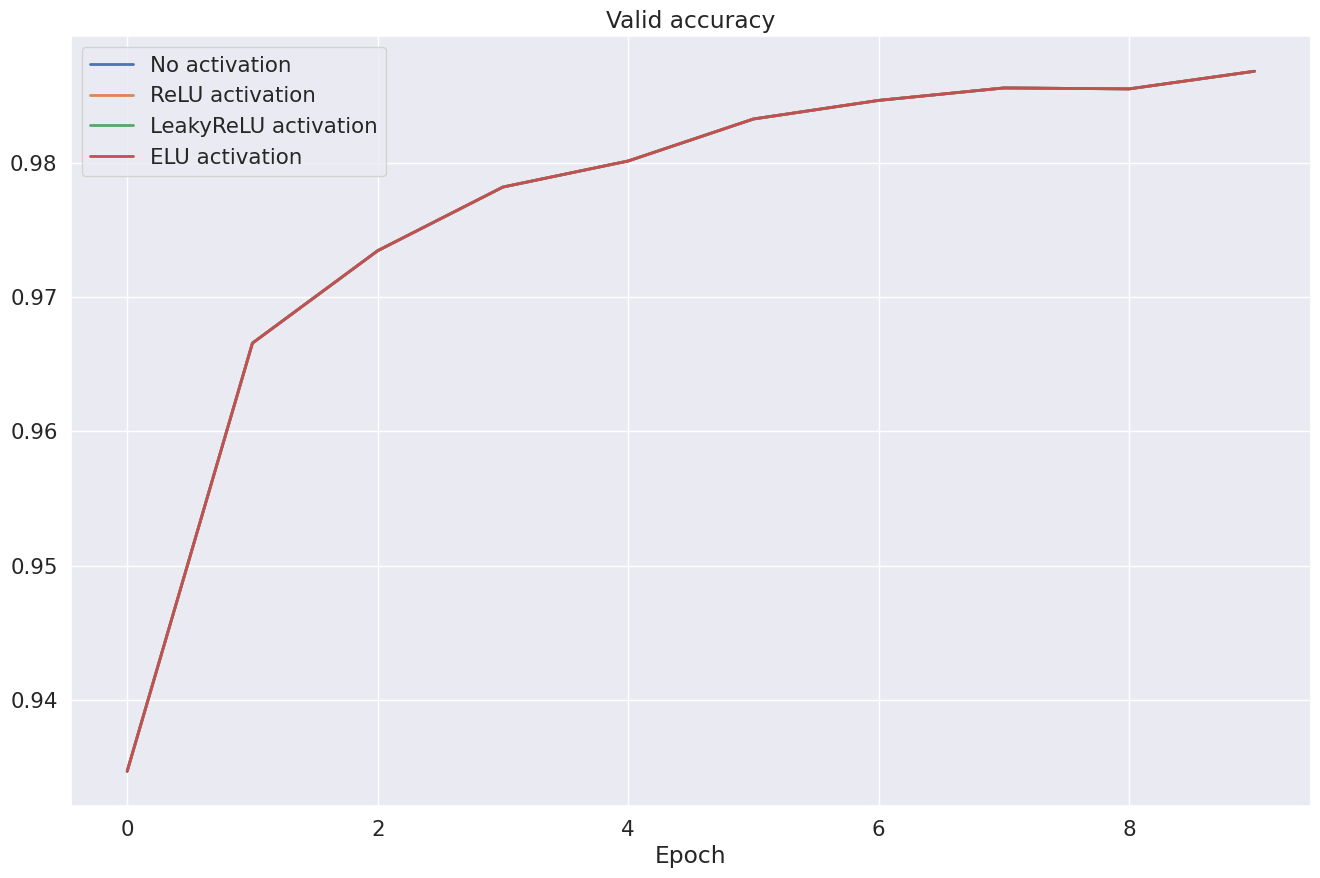

In [159]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

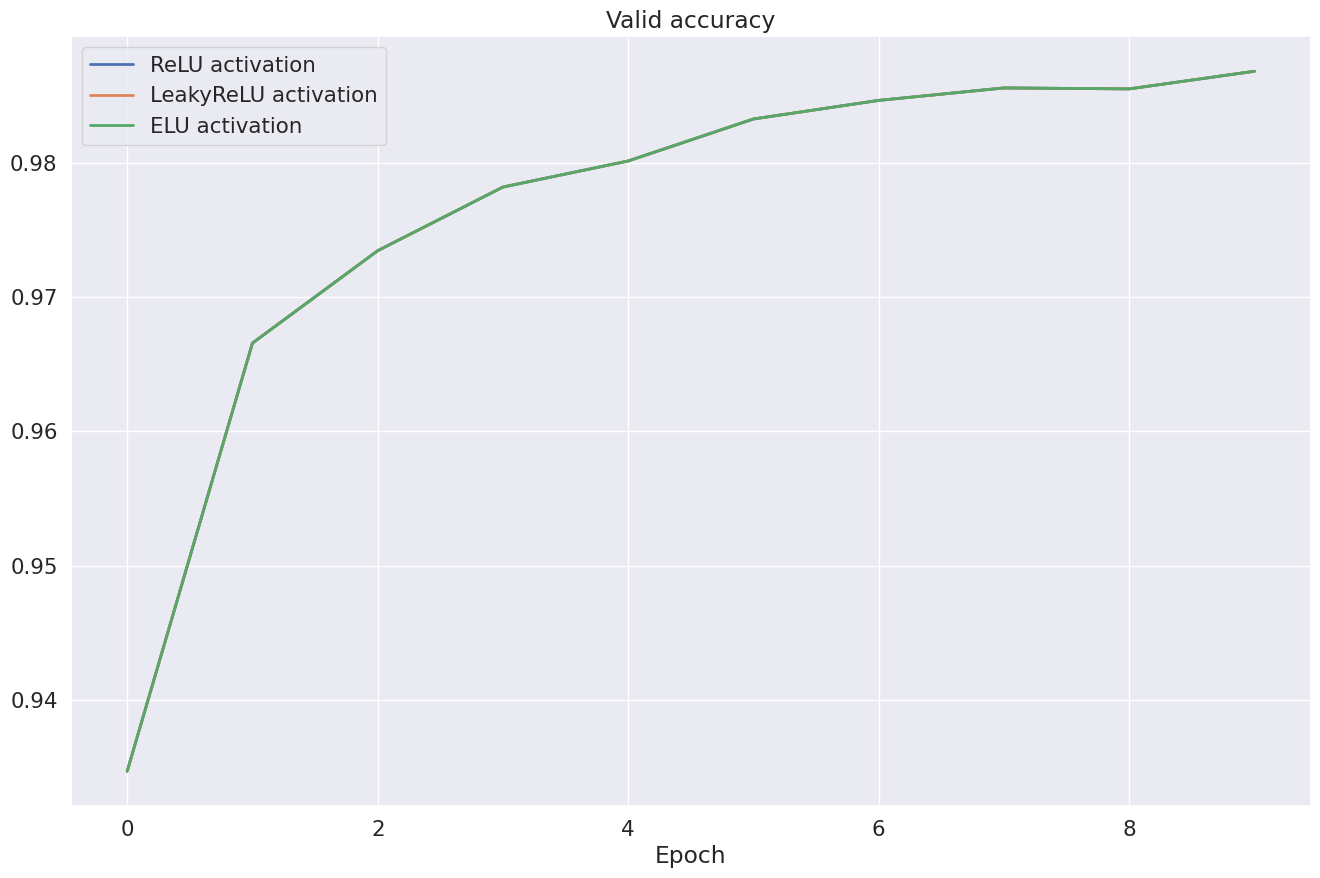

In [160]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:**

## Сверточные слои

### Ядра

In [161]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-07-31 02:11:25--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-07-31 02:11:26--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3030::6815:15c, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.01s   

2023-07-31 02:11:27 (3.

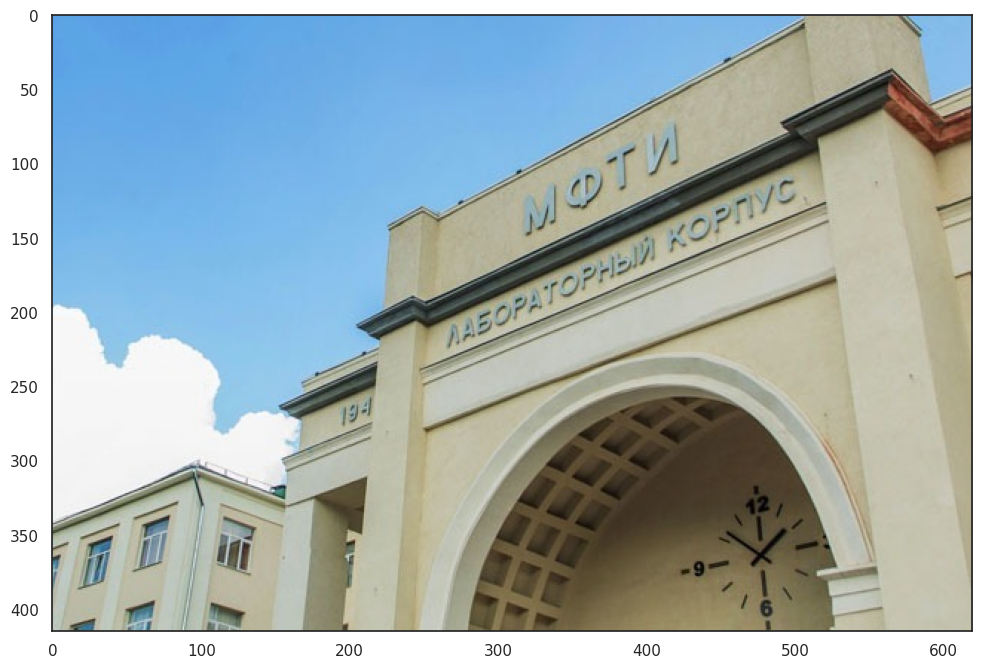

In [162]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

\Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [165]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

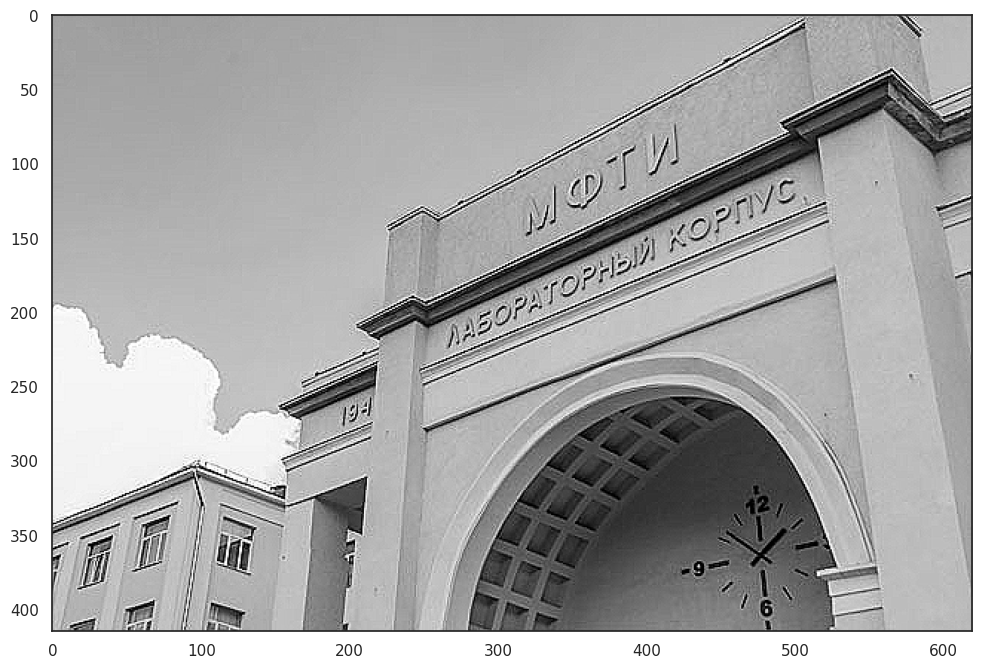

In [166]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [167]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [170]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [172]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm_notebook(range(max_epochs)):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42+epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in tqdm_notebook(dataloader):
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval()
              with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            predict = torch.max(outp, 1).indices
            correct = (y_batch == predict)
            all = len(y_batch)
            epoch_correct += int(correct.int().sum())
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

<ipython-input-172-d9b7e07cde96>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(max_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-172-d9b7e07cde96>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_batch, y_batch in tqdm_notebook(dataloader):


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9817666666666667


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9821714285714286


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9860166666666667


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9859285714285714


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.98875


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9884571428571428


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9905666666666667


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9904285714285714


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9918


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9912285714285715


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9923333333333333


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9918142857142858


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9933666666666666


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9927142857142857


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9935833333333334


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9926714285714285


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9934333333333333


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9923285714285714


  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9944


  0%|          | 0/2500 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9926857142857143


In [173]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

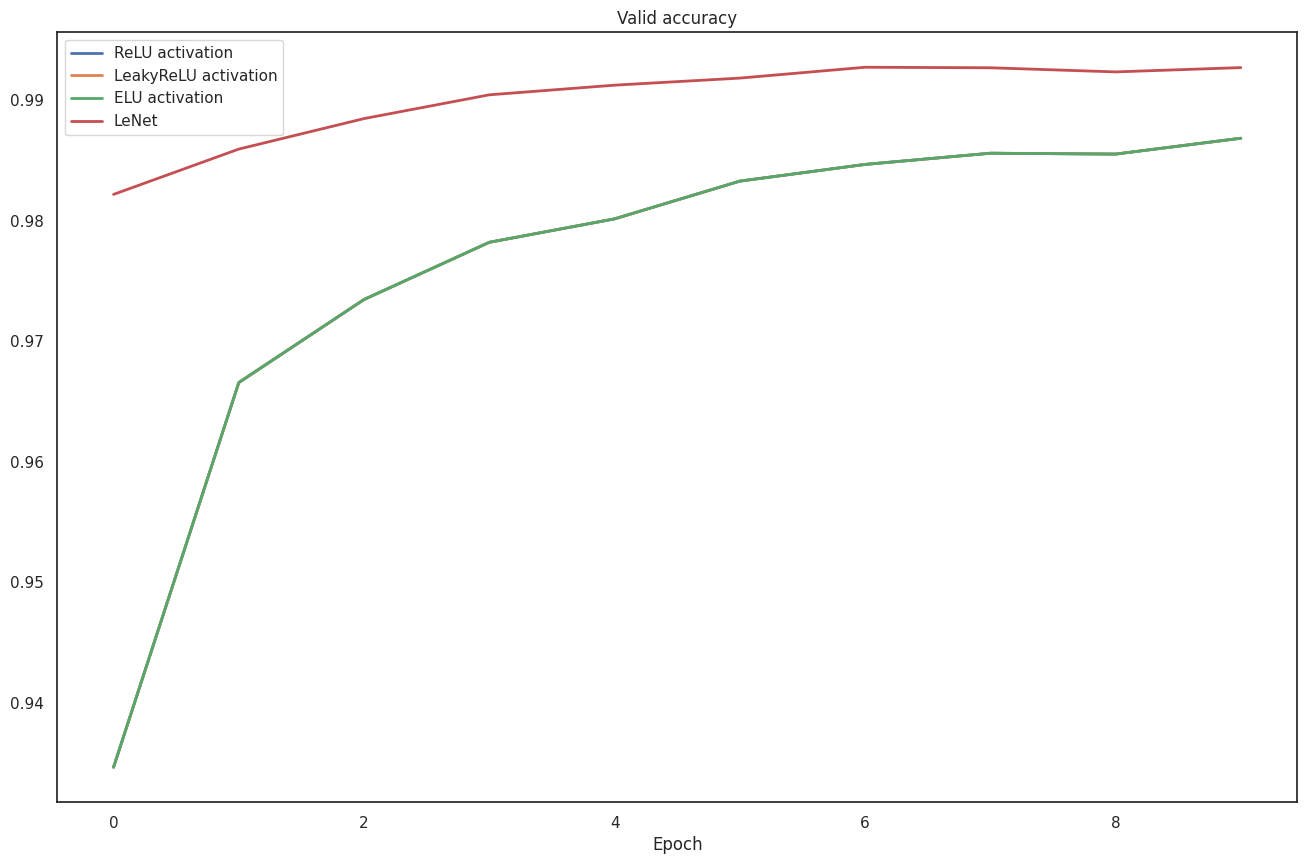

In [174]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**